In [1]:
import os

# set the environment variable to control the number of threads
# NEEDS TO BE DONE BEFORE CCL IS IMPORTED
original_omp_num_threads = os.environ.get('OMP_NUM_THREADS', None)
os.environ['OMP_NUM_THREADS'] = '1'

import pyccl as ccl
import numpy as np
import sacc
import scipy.stats.qmc as qmc
import h5py as h5
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simps

from multiprocessing import Pool, cpu_count
from parallelbar import progress_starmap
from time import time

import argparse

from generate_maml_data import bin_dndz, convolve_photoz, add_noise

In [2]:
def shift_mean(z, dndz, delta_z=0.02):
    '''
    Shift the mean redshift of the distribution.
    Args:
    z: redshift (array-like)
    dndz: redshift distribution (array-like)
    delta_z: shift in the mean redshift (float)
    '''
    mean_z = np.average(z, weights=dndz)
    delta_z *= (1 + mean_z)
    z_shift = z + delta_z
    # Ensure the redshift distribution is non-negative.
    # Clip to a very small value instead of zero 
    # to avoid division by zero
    for i in range(len(z_shift)):
        if z_shift[i] <= 0:
            z_shift[i] = 1e-10*i
    return z_shift

def compute_spectra(theta, dndz_ph_bins, z_ph, ells):
    '''
    Compute the angular power spectra for the given redshift distributions.
    Args:
    theta: cosmological parameters (array-like)
    dndz_ph_bins: redshift distributions (list of array-like)
    z_ph: redshift (array-like)
    ells: multipoles (array-like)
    shift_mean: shift in the mean redshift of the distribution (float)'''

    cosmo = ccl.Cosmology(
        Omega_c=theta[0],
        Omega_b=theta[1],
        h=theta[2],
        sigma8=theta[3],
        n_s=theta[4],
        matter_power_spectrum='halofit'
    )

    n_bins = len(dndz_ph_bins)
    inds = list(zip(*np.tril_indices(n_bins)))

    z_ph_shifted = np.empty((n_bins, len(z_ph)))
    for i in range(n_bins):
        z_ph_shifted[i] = shift_mean(
            z_ph, 
            dndz_ph_bins[i],
            delta_z=theta[5+i]
        )

    c_ells = np.empty((len(inds), len(ells)))
    for i, arg in enumerate(inds):
        j, k = arg
        tracer1 = ccl.WeakLensingTracer(
            cosmo,
            dndz=(z_ph_shifted[j], dndz_ph_bins[j])
        )
        tracer2 = ccl.WeakLensingTracer(
            cosmo,
            dndz=(z_ph_shifted[k], dndz_ph_bins[k])
        )
        c_ells[i,:] = ccl.angular_cl(cosmo, tracer1, tracer2, ells)
    
    return c_ells.flatten()

def wrap_errors(theta, dndz_ph_bins, z_ph, ells):
    '''
    Wrapper function to catch errors in parallel computation.
    Args:
    func: function to be called (callable)
    args: arguments for the function (tuple)
    '''
    try:
        return compute_spectra(theta, dndz_ph_bins, z_ph, ells)
    except Exception as e:
        # Dump data and re-raise the exception
        print('Caught exception in worker thread:')
        print('Dumping data for debugging')
        np.savez(
            os.path.join(
                'data', 'debug_worker{}.npz'.format(os.getpid())
                ),
            theta=theta,
            dndz_ph_bins=dndz_ph_bins,
            z_ph=z_ph,
            ells=ells
        )
        raise e
    
def multi_peak_nz(z, peaks):
    '''
    Generate a redshift distribution with multiple peaks.
    Args:
    z: redshift (array-like)
    peaks: peak locations (array-like)
    '''
    # Calculate the multi-peaked distribution
    dndz = np.zeros_like(z)
    for center, width, weight in peaks:
        dndz += weight * np.exp(-0.5 * ((z - center) / width) ** 2)
    return dndz

In [10]:
# Flag to say if we are generating samples representative of the MCMC data
for_mcmc = False
multi_peak = True
if for_mcmc:
    sacc_file = sacc.Sacc.load_fits('mcmc/sacc_fiducial_data.fits')

    # get redshift bins
    bins = sacc_file.tracers
    # convert into lists of redshifts and dndz
    z = []
    dndz = []
    for key in bins:
        z.append(bins[key].z)
        dndz.append(bins[key].nz)
elif multi_peak:
    peaks = [
        (0.5, 0.1, 0.3),   # Peak 1: centered at z=0.5, width=0.1, weight=0.6
        (0.75, 0.3, 0.1),   # Peak 2: centered at z=1.5, width=0.2, weight=0.3
        (3.0, 0.2, 0.6),   # Peak 3: centered at z=3.0, width=0.3, weight=0.1
    ]
    kwargs = {'peaks': peaks}
    dndz_func = multi_peak_nz
    # Generate redshift values
    z_s = np.linspace(0.05, 3.5, 300)  # Redshift range from 0 to 4
    n_bins=5
    noise_lim = 0.1
    sigma_pz = 0.05
    # Bin the redshift distribution
    z_bin, dndz_bin = bin_dndz(n_bins, z_s, dndz_func, **kwargs)

    # Convolve with photo-z and add noise to the redshift distribution
    dndz_bin_ph = np.zeros((n_bins, len(z_s)))
    noise_std = np.random.uniform(0, noise_lim)
    for j in range(n_bins):
        z_ph, dndz_bin_ph[j] = convolve_photoz(
            sigma=sigma_pz, 
            zs=z_bin[j], 
            dndz_spec=dndz_bin[j]
        )

        dndz_bin_ph[j] = add_noise(
            z_ph,
            dndz_bin_ph[j],
            noise_std
        )
    z = [z_ph, z_ph, z_ph, z_ph, z_ph]
    dndz = dndz_bin_ph
else:
    #### OR choose another dndz ####
    # Load a distribution from original training sample
    filepath = 'data/1000tasks_5000samples_44seed.h5'
    f = h5.File(filepath, 'r')

    data_ind = 42
    z = f['z'][data_ind]
    dndz = f['dndz'][data_ind]

# check all z arrays are the same
assert all([np.allclose(z[0], z[i]) for i in range(1, len(z))])

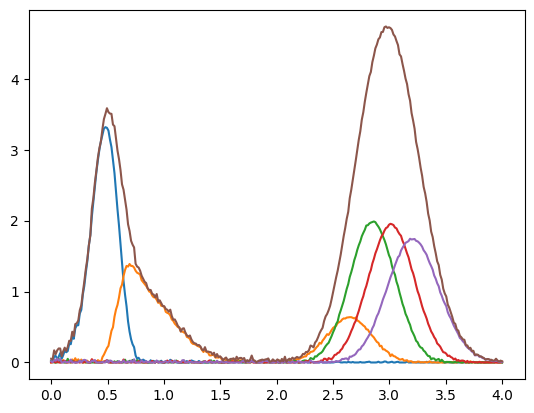

In [11]:
# Plot the redshift distribution
for i in range(len(z)):
    plt.plot(z[i], dndz[i], label='Bin {}'.format(i))
plt.plot(z[0], np.sum(dndz, axis=0), label='Total')

In [12]:
n_samples = 30000

# Now we compute samples in parallel
# Start by constructing the latin hypercube
# Construct parameter hypercube from DES Y3 priors
Omega_m = np.array([0.05, 0.95])
Omega_b = np.array([0.025, 0.075])
Omega_c = Omega_m - Omega_b

h = np.array([0.55, 0.91])
n_s = np.array([0.87, 1.07])
sigma8 = np.array([0.6, 0.9])

delta_z = np.array([-0.02, 0.02])# times 5 bins

hyperframe = qmc.LatinHypercube(d=10)
hyperunits = hyperframe.random(n_samples)

# Rescale the hypercube for provided param ranges
l_bounds = np.array([
    Omega_c[0], Omega_b[0], h[0], sigma8[0], n_s[0],
    delta_z[0], delta_z[0], delta_z[0], delta_z[0], delta_z[0]
])
u_bounds = np.array([
    Omega_c[1], Omega_b[1], h[1], sigma8[1], n_s[1],
    delta_z[1], delta_z[1], delta_z[1], delta_z[1], delta_z[1]
])
hypercube = qmc.scale(hyperunits, l_bounds, u_bounds)

# Construct arglist for parallel computation of
# the angular power spectra
ells = np.geomspace(2, 5000, 50)
arglist = [
    (hypercube[i], dndz, z[0], ells)
    for i in range(n_samples)
]

start = time()

# Compute the angular power spectra in parallel
n_threads = cpu_count()
c_ells = progress_starmap(
    wrap_errors,
    arglist,
    n_cpu=n_threads
)

end = time()
print('Time taken: {}s'.format(end - start))

DONE:   0%|          | 0/30000 [00:00<?, ?it/s]

Time taken: 1184.6846373081207s


In [13]:
# Write C_ells and cosmology to h5 file
if for_mcmc:
    filename = 'mcmc_dndz_nsamples={}.h5'.format(n_samples)
elif multi_peak:
    filename = 'multi_peak_dndz_nsamples={}.h5'.format(n_samples)
else:
    filename = '{}_dndz_nsamples={}.h5'.format(data_ind, n_samples)

with h5.File(filename, 'w') as f:
    f.create_dataset('c_ells', data=c_ells)
    f.create_dataset('hypercube', data=hypercube)
    f.create_dataset('ells', data=ells)
    f.create_dataset('z', data=z[0])
    f.create_dataset('dndz', data=dndz) 